# Multi Armed Bandits - Reinforcement Learning

![img](http://www.technik-aktuell.de/wp-content/uploads/2013/12/1890-zoom-1.jpg)

##### Introduction

This notebook is an introduction on Deep Reinforcement Learning to solve a very simple problem : **the Bandit problem**. <br>
More information on https://en.wikipedia.org/wiki/Multi-armed_bandit <br>
Imagine you are playing at the casino at a Bandit machine. **Each arm or bandit has its own likelihood to win the prize**. <br>
The goal is then to optimize the choices of the bandits to maximize the earnings using Reinforcement Learning. <br><br>

It is a very simple yet interesting situation, that can be replicated for any system where a Bayesian approach would be useful : 
- Allocating budget and time for a project
- Choosing a vaccine for a disease between multiple versions
- Choosing the correct ad on a page

I will then try to **model this problem** and **conduct some experiments** to discover with a simple use case the field of Reinforcement Learning.




###### Links and references

- [Udemy course on RL](https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python/)
- [Siraj Raval Video on RL](https://www.youtube.com/watch?v=AIeWLTUYLZQ)
- [Stanford Course on Computer Vision](http://cs231n.github.io/neural-networks-2/) link interesting to understand to loss function used here
- [Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/) Andrej Karpathy's blog article on RL (always a reference)
- [Play TORCS with Keras and PG](https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html) nice reference


##### Libraries

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append("C:/git/alan")

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
% matplotlib inline

# Seaborn config
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

# Deep Learning (Keras, Tensorflow)
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D,ZeroPadding2D,Conv2D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


***

# Set up the environment
We need to create the environment to model this problem by : 
- Defining the bandits
- Creating a Neural Network to learn from experience
- Run an episode (one try of pulling an arm to win a reward)
- Run a game (multiple tries where at the end we predict which arm is the more likely to help us win money)

## Define the Bandits
Let's set up a class to define the Bandit object

In [20]:
class Bandit(object):
    def __init__(self,p = None):
        '''Simple bandit initialization'''
        self.p = p if p is not None else np.random.random()
        
    def pull(self):
        '''Simulate a pull from the bandit
           
        '''
        if np.random.random() < self.p:
            return 1
        else:
            return -1
        
def create_list_bandits(n = 4,p = None):
    if p is None: p = [None]*n
    bandits = [Bandit(p = p[i]) for i in range(n)]
    return bandits

We can define a list of bandits with random probabilities

In [21]:
bandits = create_list_bandits()
print(">> Probabilities to win : {}".format([x.p for x in bandits]))

>> Probabilities to win : [0.214117875860533, 0.0934257582168162, 0.875196022370943, 0.5460573168403362]


Or fix some probabilities to given values

In [22]:
bandits = create_list_bandits(p = [None,None,None,0.8])
print(">> Probabilities to win : {}".format([x.p for x in bandits]))

>> Probabilities to win : [0.1595218071824519, 0.5103302424486803, 0.5946058413979742, 0.8]


## Create the Neural Network
We are going to use a simple fully connected feed-forward Neural Network using Keras. <br>
The Neural Network will have 2 hidden layers of 100 units, and will be optimized with Stochastic Gradient Descent

In [23]:
def build_fcc_model(H = 100,lr = 0.1,dim = 4):
    model = Sequential()
    model.add(Dense(H, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(H))
    model.add(Activation('relu'))

    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)


    model.add(Dense(dim))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    return model


model = build_fcc_model()


## Episode

### Sampling action with epsilon greedy strategy
At each step we will have the choice between all the bandits :  
- At the first step we don't know anything, so we may consider each of them with the same probability
- Then we update our probabilities according to our experience

We must then sample our action (pulling a bandit arm) from the probability space. <br>
Example : imagine at one time step the probabilities are [0.75,0.1,0.15] for 3 bandits. We would want to pull the first bandit 75% of the time. 

However, maybe we are stuck in a local minima, and the first is not the best bandit. We may want to explore more the other options. <br>
This is called the **exploration-exploitation dilemma**. <br>
One nice and simple approach is the epsilon-greed strategy, which consists in : 
- **EXPLOITATION**, sampling from the probabilities epsilon % of the time
- **EXPLORATION**, taking a random action to continue explore our options 

In [75]:
def sample_action(probas,epsilon = 0.2):
    probas = probas[0]
    if np.random.rand() < epsilon:
        choice = np.random.randint(0,len(probas))
    else:
        choice = np.random.choice(range(len(probas)),p = probas)
    return choice

### Run an episode
One episode is "pulling an arm", the model here is : 
- Taking the probabilities as input (our perception about if the bandits are more likely to be better) (at the first step we don't know each has the same probability)
- We choose one bandit to pull by sampling from the probability space
- We receive a reward (+1 or -1) representing our win/loss
- We update our knowledge by backpropagating the reward impact in the gradient via gradient descent to update the weights of the Neural Network
- We get our new perception of the probabilities to win (better if a bandit resulted a +1 reward, worse otherwise)

In [39]:
def run_episode(bandits,model,probas = None,train = True,epsilon = 0.2):
    
    if probas is None:
        probas = np.ones((1,len(bandits)))/len(bandits)
    
    # sampling action
    bandit_to_pull = sample_action(probas,epsilon = epsilon)
    action = to_categorical(bandit_to_pull,num_classes=probas.shape[1])
    
    # reward
    reward = bandits[bandit_to_pull].pull()
    
    # feed vectors
    X = action
    y = (action - probas)*reward
        
    if train:
        model.train_on_batch(X,y)
        
    # update probabilities
    probas = model.predict(X)
    
    return reward,probas

## Game
A game is the usual terminology when speaking about running multiple episodes. <br>
At the end (after a given number of tries) we will check if what we think is the best bandit is actually the best. <br>
To model a game, we will : 
- Create a list of bandits to test
- Create a Neural Network to model our knowledge along the game
- Prepare some buffers to store the rewards and probabilities
- Iterate on a given number of episodes
- Check if we correctly predicted the best bandit
- Plot the probabilities over time and the average running reward during the experience

In [40]:
def run_game(n_episodes = 100,lr = 0.1,n_bandits = 4,p = None,epsilon = 0.2):

    # DEFINE THE BANDITS
    bandits = create_list_bandits(n = n_bandits,p = p)
    probabilities_to_win = [x.p for x in bandits]
    best_bandit = np.argmax(probabilities_to_win)
    print(">> Probabilities to win : {} -> Best bandit : {}".format(probabilities_to_win,best_bandit))

    # INITIALIZE THE NEURAL NETWORK
    model = build_fcc_model(lr = lr,dim = n_bandits)
    
    # INITIALIZE BUFFERS
    rewards = []
    avg_rewards = []
    all_probas = np.array([])
    
    # EPISODES LOOP
    for i in range(n_episodes):
        print("\r[{}/{}] episodes completed".format(i+1,n_episodes),end = "")

        # Random choice at the first episode
        if i == 0:
            reward,probas = run_episode(bandits = bandits,model = model,epsilon = epsilon)
            
        # Updated probabilities at the following episodes
        else:
            reward,probas = run_episode(bandits = bandits,model = model,probas = probas)

            
        # Store the rewards and the probas
        rewards.append(reward)
        avg_rewards.append(np.mean(rewards))
        all_probas = np.append(all_probas,probas)
        
    print("")
    
    
    # GET THE BEST PREDICTED BANDIT
    predicted_bandit = np.argmax(probas)
    print(">> Predicted bandit : {} - {}".format(predicted_bandit,"CORRECT !!!" if predicted_bandit == best_bandit else "INCORRECT"))

    
    # PLOT THE EVOLUTION OF PROBABILITIES OVER TRAINING
    all_probas = all_probas.reshape((n_episodes,n_bandits)).transpose()
    plt.figure(figsize = (12,5))
    plt.title("Probabilities on Bandit choice - {} episodes - learning rate {}".format(n_episodes,lr))
    for i,p in enumerate(list(all_probas)):
        plt.plot(p,label = "Bandit {}".format(i),lw = 1)
        
    plt.plot(avg_rewards,linestyle="-", dashes=(5, 4),color = "black",lw = 0.5,label = "average running reward")
    plt.legend()
    plt.ylim([-0.2,1])
    
    plt.show()


>> Probabilities to win : [0.95, 0.05] -> Best bandit : 0
[250/250] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


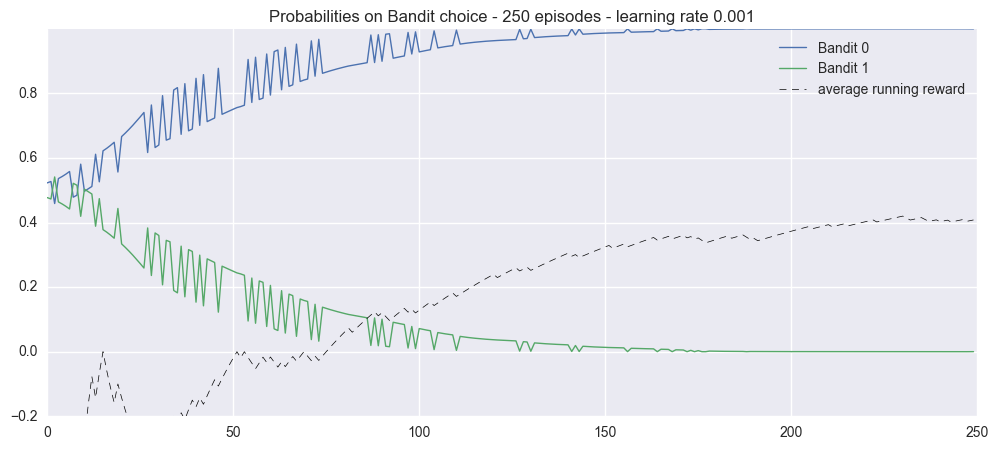

In [42]:
run_game(250,lr = 0.001,n_bandits = 2,p = [0.95,0.05])

# Experiments

## Game with 2 bandits

### Playing with the learning rate
Let's look at how fast we can learn and find the best bandit, by tweaking the learning rate of the optimizer.

>> Probabilities to win : [0.95, 0.05] -> Best bandit : 0
[100/100] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


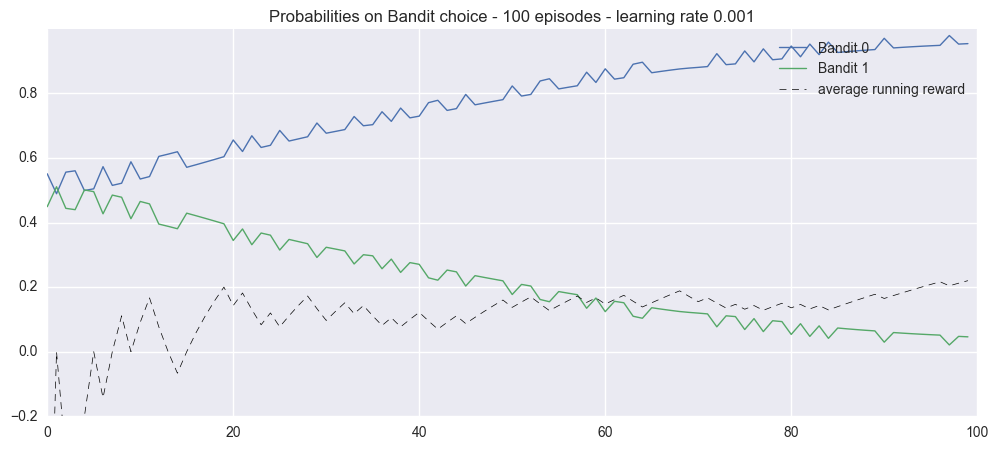

In [47]:
run_game(100,lr = 0.001,n_bandits = 2,p = [0.95,0.05])

>> Probabilities to win : [0.95, 0.05] -> Best bandit : 0
[100/100] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


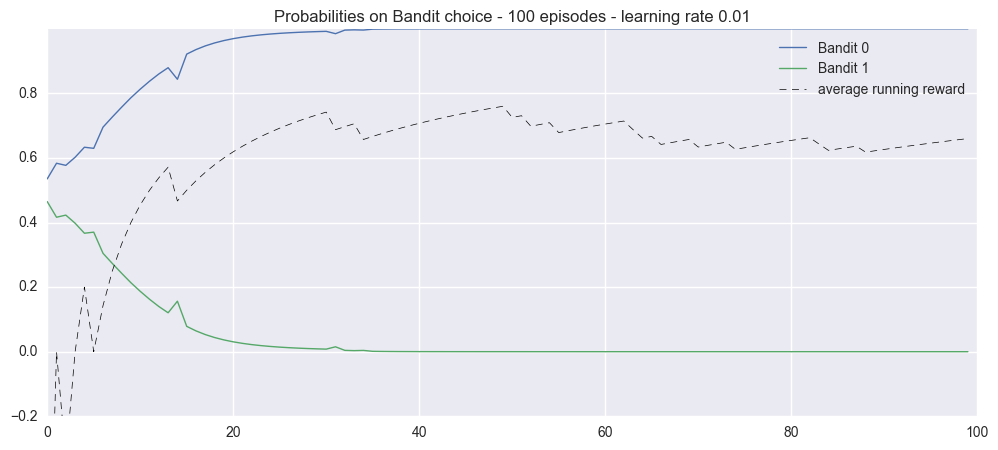

In [48]:
run_game(100,lr = 0.01,n_bandits = 2,p = [0.95,0.05])

In only 10 episodes we are already extremely confident in the best bandit

>> Probabilities to win : [0.95, 0.05] -> Best bandit : 0
[100/100] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


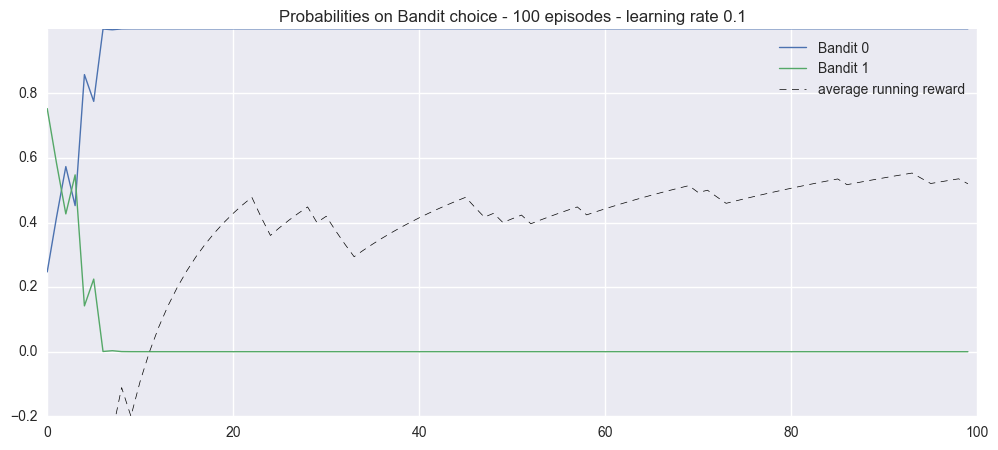

In [50]:
run_game(100,lr = 0.1,n_bandits = 2,p = [0.95,0.05])

### Playing with the probabilities
The game here was very simple, with very different probabilities (one that wins most of the time, one that loses). Let's try with closer probabilities. <br>

And indeed, our perception is more uncertain but finishes by choosing the best bandit.

>> Probabilities to win : [0.55, 0.45] -> Best bandit : 0
[250/250] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


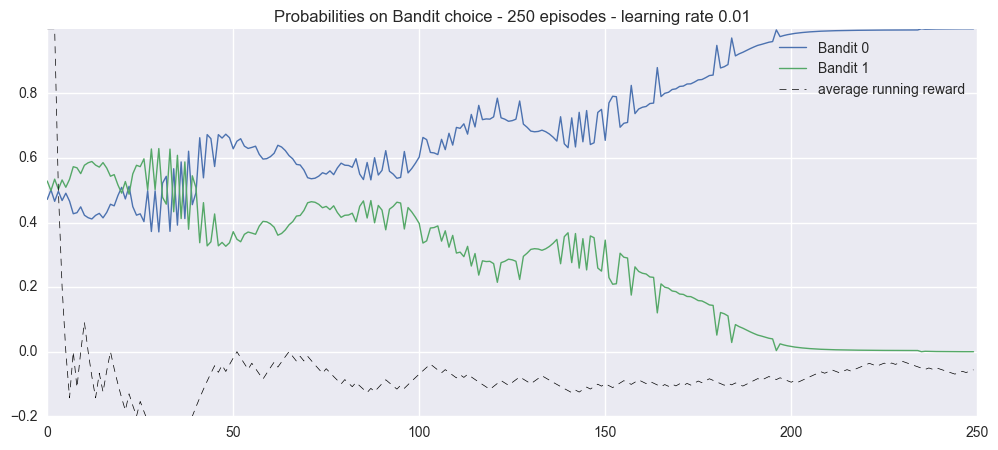

In [54]:
run_game(250,lr = 0.01,n_bandits = 2,p = [0.55,0.45])

>> Probabilities to win : [0.55, 0.45] -> Best bandit : 0
[250/250] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


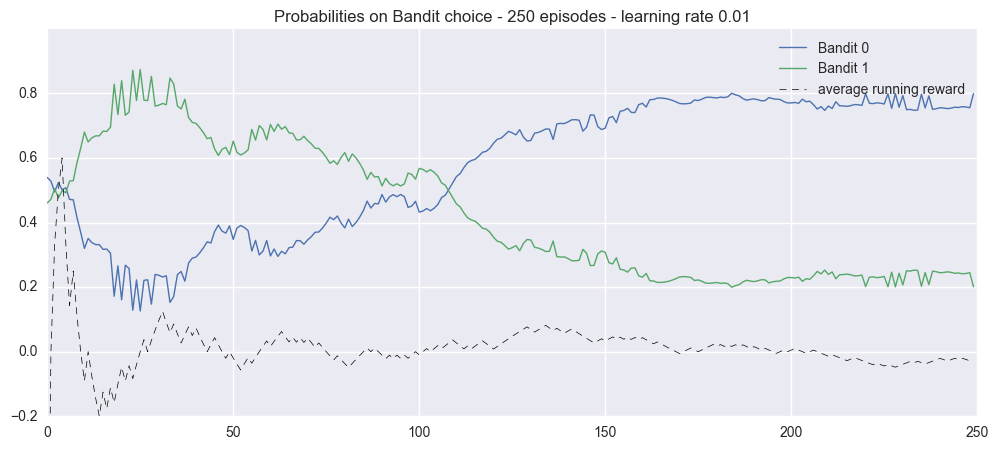

In [55]:
run_game(250,lr = 0.01,n_bandits = 2,p = [0.55,0.45])

>> Probabilities to win : [0.55, 0.45] -> Best bandit : 0
[250/250] episodes completed
>> Predicted bandit : 0 - CORRECT !!!


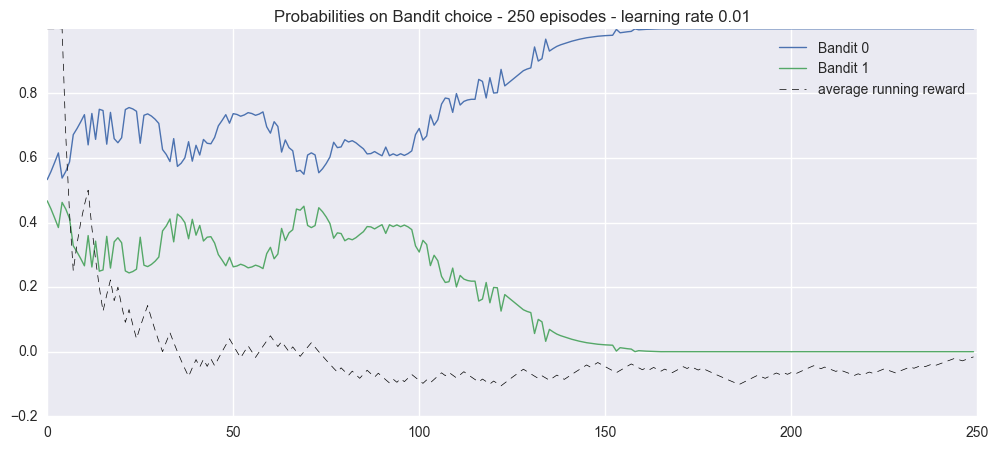

In [56]:
run_game(250,lr = 0.01,n_bandits = 2,p = [0.55,0.45])

## Game with 4 bandits

We can correctly predict also for 4 bandits

>> Probabilities to win : [0.041332346852162916, 0.42877333492000136, 0.0806253507587118, 0.7821646405747448] -> Best bandit : 3
[250/250] episodes completed
>> Predicted bandit : 3 - CORRECT !!!


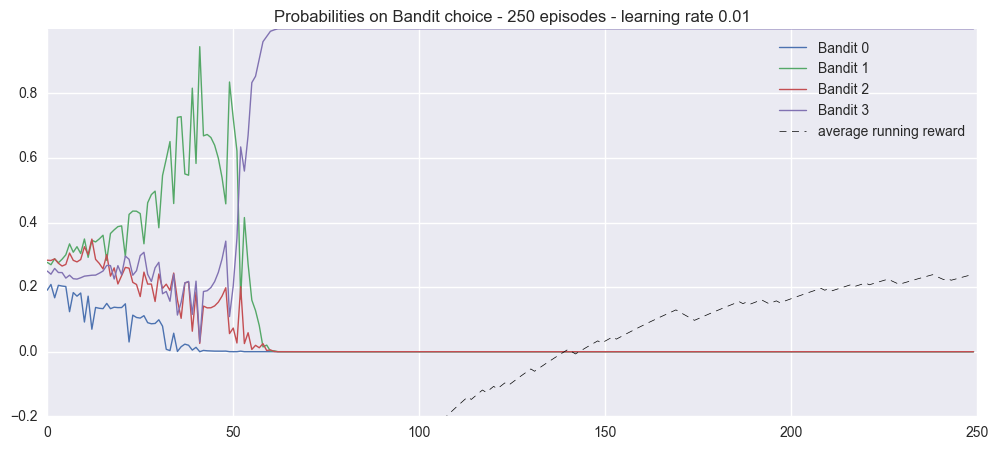

In [83]:
run_game(250,lr = 0.01,n_bandits = 4)

>> Probabilities to win : [0.46773780735830295, 0.15980763678859877, 0.5992361859635028, 0.8234299889691397] -> Best bandit : 3
[250/250] episodes completed
>> Predicted bandit : 3 - CORRECT !!!


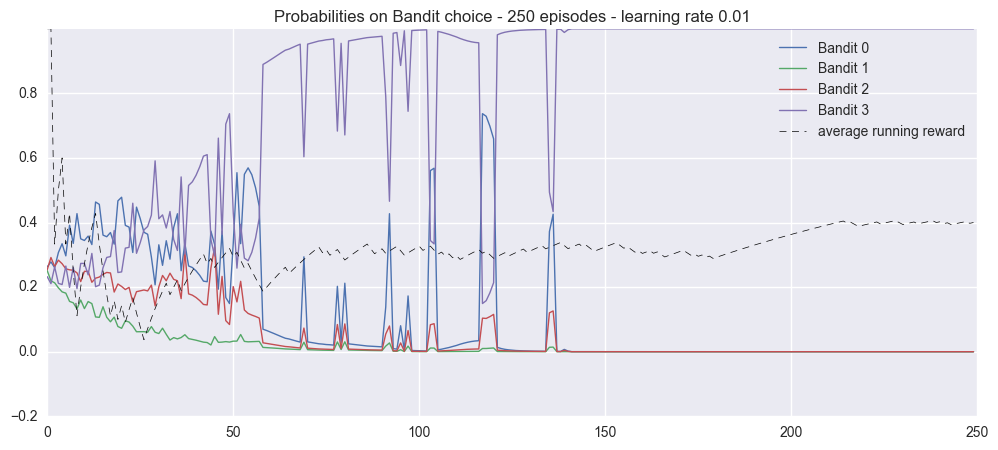

In [84]:
run_game(250,lr = 0.01,n_bandits = 4)

##### Sometimes it does not work
Here the bandits 1,2 and 3 have similar probabilities. And indeed, we hesitate between the 1 and 3. <br>
But very quickly we know that the bandit 0 is the correct one. 

>> Probabilities to win : [0.1834522328809104, 0.46678068352242974, 0.4173712230331247, 0.4851981366466076] -> Best bandit : 3
[250/250] episodes completed
>> Predicted bandit : 1 - INCORRECT


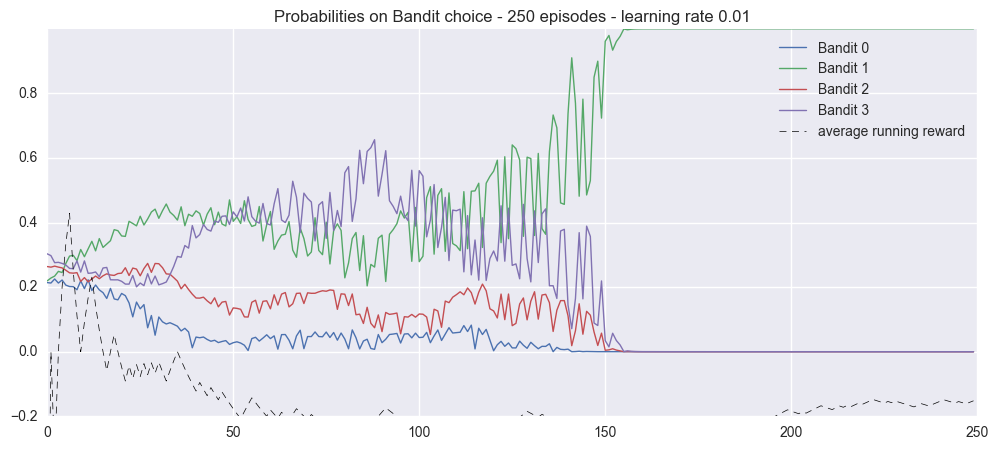

In [85]:
run_game(250,lr = 0.01,n_bandits = 4)

With a smaller learning rate

>> Probabilities to win : [0.7006013982439953, 0.38198213461248465, 0.7765990557014593, 0.1064468572534436] -> Best bandit : 2
[1000/1000] episodes completed
>> Predicted bandit : 2 - CORRECT !!!


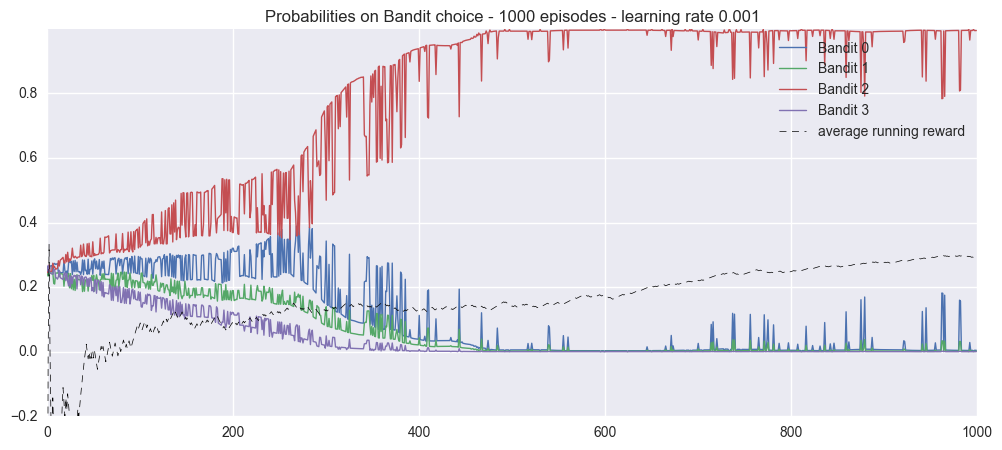

In [87]:
run_game(1000,lr = 0.001,n_bandits = 4)

## Game with more bandits

>> Probabilities to win : [0.7214291516700608, 0.20562888759173115, 0.7040153667439021, 0.03386199732387085, 0.5487770837724718, 0.45406618976426616, 0.9848043259850778, 0.309097608158602, 0.4727152746308876, 0.49677022782969904] -> Best bandit : 6
[1000/1000] episodes completed
>> Predicted bandit : 6 - CORRECT !!!


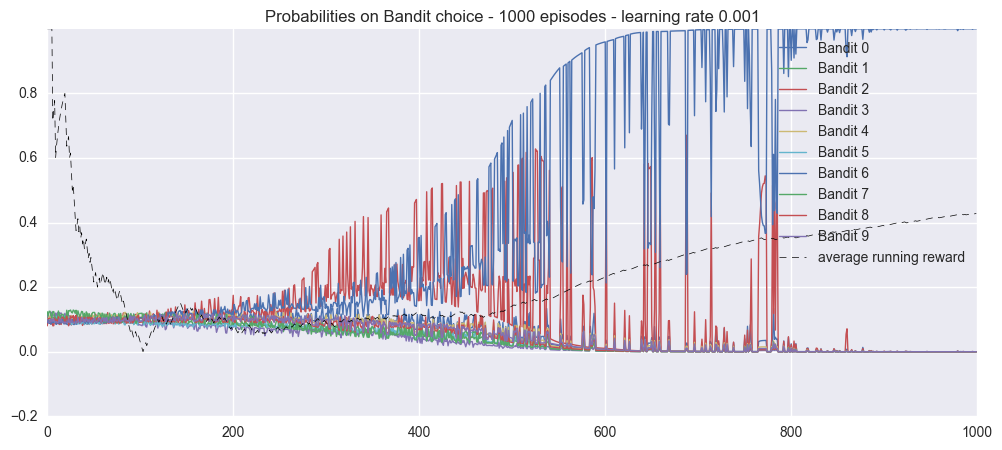

In [95]:
run_game(1000,lr = 0.001,n_bandits = 10)

>> Probabilities to win : [0.8057881868856852, 0.36091118721087434, 0.26958960317253033, 0.6099364982597577, 0.25705276609123306, 0.9343741395726503, 0.4415667467545259, 0.9677365379308619, 0.7292645357572228, 0.619072555901256] -> Best bandit : 7
[1000/1000] episodes completed
>> Predicted bandit : 7 - CORRECT !!!


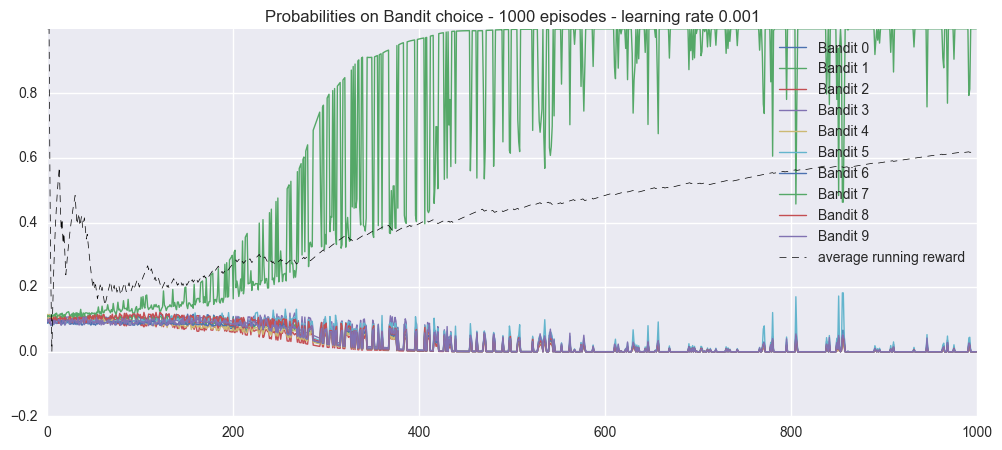

In [96]:
run_game(1000,lr = 0.001,n_bandits = 10)

It may not work, but we are still able to find among the best bandits. 

>> Probabilities to win : [0.877971658331, 0.1487076485646971, 0.4564885839501438, 0.48883408599073996, 0.03653886570593878, 0.8953843603123536, 0.37550511059970737, 0.8527763985260793, 0.15280451127792516, 0.3488985365575469] -> Best bandit : 5
[1000/1000] episodes completed
>> Predicted bandit : 0 - INCORRECT


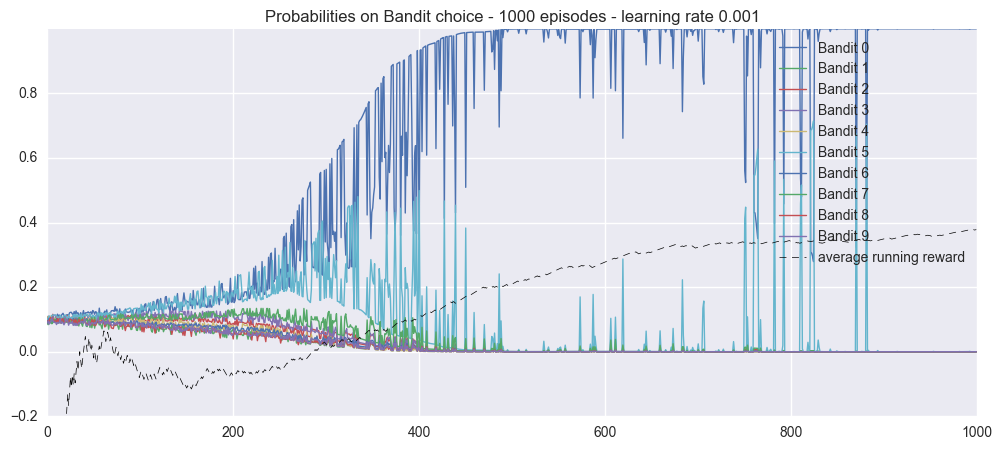

In [94]:
run_game(1000,lr = 0.001,n_bandits = 10)